# Limits of Diversification

* Diversification cannot help manage systematic risk
* Hedging is effective at managing systematci risk but you have to give up on the upside as well
* Insurance = dynamic hedging. Can offers the best of both worlds

## Lab Session - Limits of Diversification

Why doesnt diversification help you in market crashes?

One reason is that correlations across assets increases as the market drops. Let's see if we can see this in the data.

Let's load up the industry data that we've used in the past.

In [5]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
ind_return = erk.get_ind_returns()
ind_return.sample(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1951-07,0.0315,0.0527,0.0307,0.0721,0.0192,0.0735,0.0107,0.1442,0.0816,0.0235,...,0.0280,0.0140,0.0739,0.0651,0.0846,0.1136,0.0245,0.0377,0.0591,0.0490
1988-02,0.0420,0.0547,0.0614,0.1033,0.0721,0.0293,0.1173,0.0420,0.0812,0.2311,...,0.0132,0.0622,0.0737,0.0788,0.0870,0.0829,0.1186,0.0709,0.0303,0.0358
1939-04,0.0170,-0.0197,-0.0073,0.0153,0.0484,0.0121,-0.0057,0.0100,-0.0172,-0.0161,...,0.0275,0.0259,-0.0727,-0.0007,-0.0230,0.0033,-0.0016,0.0100,-0.0333,-0.0153


### Implementing a Cap-Weighted Portfolio

Most market indices are constructed by taking a set of assets and weighting them by their market equity aka market capitalization.

Let's construct a market cap weighted index from our 30 industry portfolios.

For each of these industries, we also have data on the number of stocks in each industry as well as the average market cap in each industry. Thus, we can multiply the average market cap by the number of companies to get the total market capitalization of each industry. We can then weight each industry portfolio proportional to the market capitalization of that industry.

In [9]:
ind_nfirms = erk.get_ind_nfirms()
ind_size = erk.get_ind_size()

In [10]:
ind_mktcap = ind_nfirms * ind_size

Now that we have the market caps for each month, we can compute the total market capitalization over time by summing over all industries:

In [11]:
total_mktcap = ind_mktcap.sum(axis=1) # sum accross columns
total_mktcap.shape

(1110,)

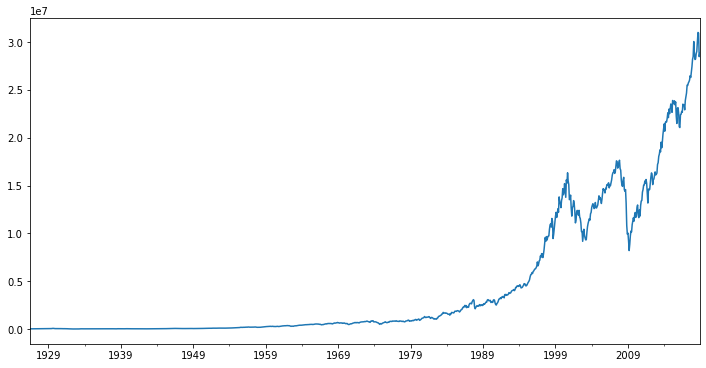

In [14]:
total_mktcap.plot(figsize=(12, 6));

Now that we have the market caps for each month, we can compute the total market capitalization over time by summing over all industries:

In [16]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")

Let's verify that the sum of the cap weights of all the columns should always sum to 1.

Because these are floating point numbers, it is not a good idea to test if they sum to 1 by using `== 1.0`. Instead, we make sure they are very close to 1 as follows

In [18]:
ind_capweight["1990"].sum(axis="columns")

1990-01    1.0
1990-02    1.0
1990-03    1.0
1990-04    1.0
1990-05    1.0
1990-06    1.0
1990-07    1.0
1990-08    1.0
1990-09    1.0
1990-10    1.0
1990-11    1.0
1990-12    1.0
Freq: M, dtype: float64

In [17]:
all(abs(ind_capweight.sum(axis="columns") - 1) < 1E-10)

True

In [23]:
ind_capweight.columns

Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'],
      dtype='object')

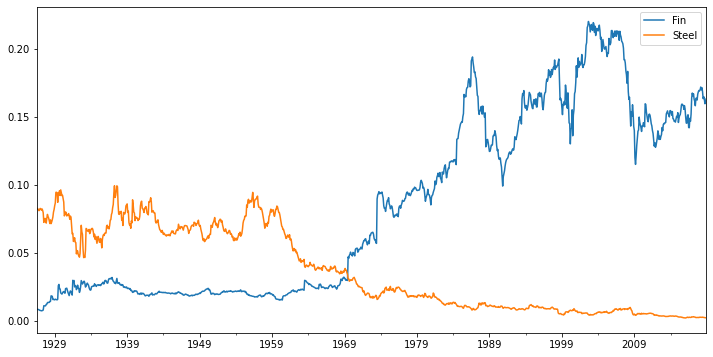

In [40]:
# Let's look at the fraction of the market occupied by the Steel industry over time 
# and compare it with the Finance industry.
ind_capweight[["Fin", "Steel"]].plot(figsize=(12,6));

### Constructing a Cap Weighted Market Index

One way to construct a market index is to build a portfolio whose weights are rebalanced back to the target weights every period. In reality, the weights may drift over time but this simplification is close enough.

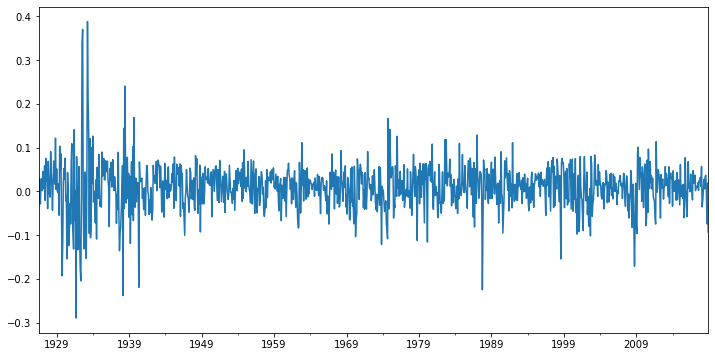

In [39]:
total_market_return = (ind_capweight * ind_return).sum(axis="columns")
total_market_return.plot(figsize=(12, 6));

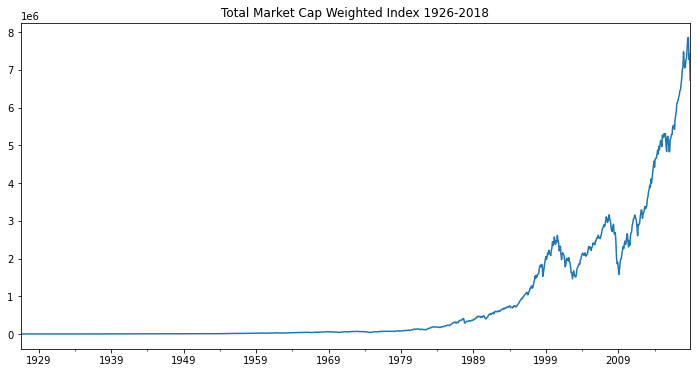

In [33]:
# Now, we want to take these returns and convert it into a total market index.
# That is nothing more than the wealth index derived from those returns.
# Which is already implemented in the drawdown method:
total_market_index = erk.drawdown(total_market_return).Wealth
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018", figsize=(12,6));

### Rolling Windows

Let's construct a rolling window of returns over a trailing 36 month period. Pandas contains direct support for rolling windows, and allows you to aggregate the returns over a window. In our case, lets compute the average return over a trailing 36 month window.

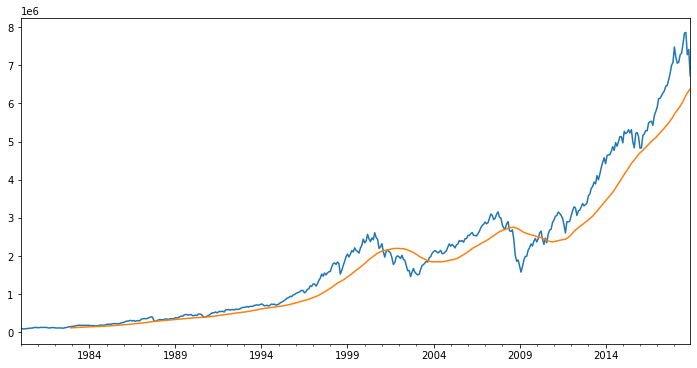

In [35]:
total_market_index["1980":].plot(figsize=(12, 6))
total_market_index["1980":].rolling(window=36).mean().plot();

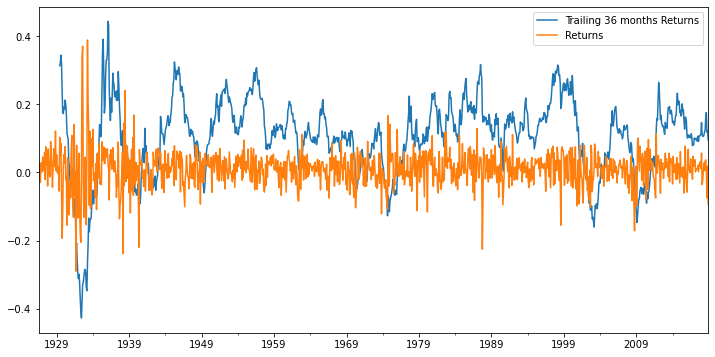

In [38]:
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(erk.annualize_rets, 
                                                                periods_per_year=12)
tmi_tr36rets.plot(figsize=(12,6), label="Trailing 36 months Returns", legend=True)
total_market_return.plot(label="Returns", legend=True);

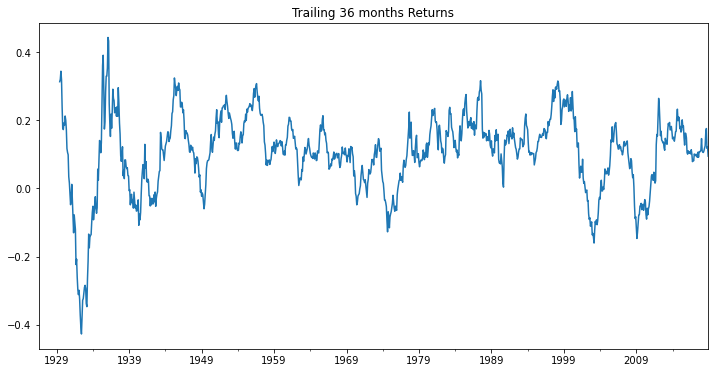

In [42]:
# Let's just keep the trailing 36 months returns
# We can see that the market crashed many times in the past
tmi_tr36rets.plot(figsize=(12,6), title="Trailing 36 months Returns");

### Rolling Correlations: Multi Indexes and `.groupby`

Next we want to look at average correlations between all the industries over that same trailing 3 year window.

Let's start by contructing the time series of correlations over time over a 36 month window.

In [43]:
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
2018-12 Whlsl  0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail  0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals  0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin    0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other  0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                  Clths      Hlth     Chems     Txtls  ...     Telcm  \
2018-12 Whlsl  0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail  0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals  0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin    0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other  0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                  Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
2018-12 Whlsl  0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail  0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals  0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin    0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other  0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                  Meals       Fin     Other  
2018-12 Whlsl  0.643879  0.746480  0.767652  
        Rtail  0.616947  0.611883  0.619918  
        Meals  1.000000  0.502563  0.605226  
        Fin    0.502563  1.000000  0.734837  
        Other  0.605226  0.734837  1.000000  

[5 rows x 30 columns]

What is created is a DataFrame with a MultiLevel Index. The first level is the date and the second level is industry name. Interpretation: on 2018-12 the correlation between food and retail was 51.8% and so on.

In [44]:
# We can make this easier to see if we give names to the levels of the index:
ts_corr.index.names = ['date', 'industry']
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

To compute the rolling correlations, we need to group all the rows for the same date, and then compute the average across all the entries in the dataframe. 

We need to compute the mean of all the values of the dataframe, not the mean of each column. We could compute the means of the means, but it's simpler to just call our own function on the correlation matrix.

Although we could construct a function to compute this, it's often easier to provide a `lambda` function which is a simple one-time-use function and therefore has no name. In every other way, it's a standard pandas function.

We do so as follows:

In [45]:
ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())

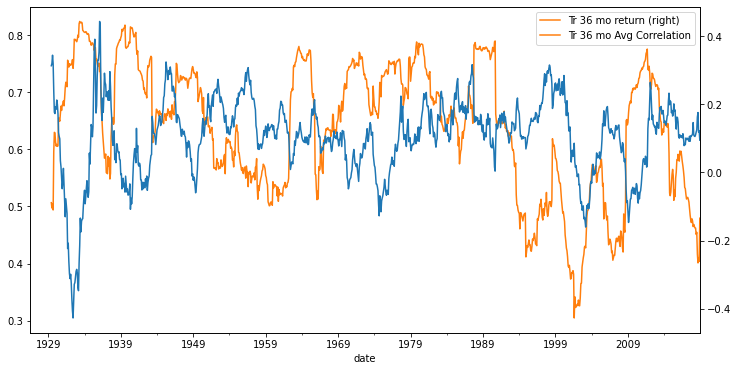

In [47]:
tmi_tr36rets.plot(secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr.plot(legend=True, label="Tr 36 mo Avg Correlation");

In [48]:
tmi_tr36rets.corr(ind_tr36corr)

-0.28010065062884126

Clearly, these two series are negatively correlated, which explains why diversification fails you when you need it most. When markets fall, correlations rise, making diversification much less valuable.

Instead, we'll look at how to use Insurance to protect the downside.

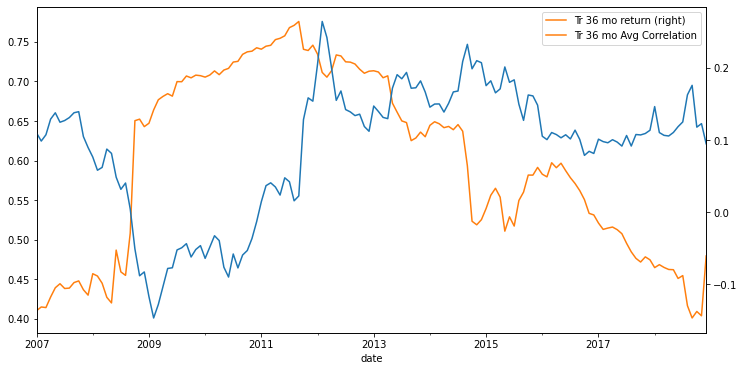

In [49]:
tmi_tr36rets["2007":].plot(secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr["2007":].plot(legend=True, label="Tr 36 mo Avg Correlation");

Obviously diversification is not going to help in market crashes!